In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import Tool
import numpy as np
import tqdm
import tejapi
from datetime import datetime, timedelta

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [109]:
twse = tejapi.get('TWN/APIPRCD', coid='IX0001',opts={'columns': ['mdate','roi','close_d','vol','low_d']}, mdate={'gte': '2010-01-01', 'lte':'2025-04-21'}, paginate=True)

In [110]:
twse['roi'] = (twse['roi'] / 100).shift(-2)

In [ ]:
from src import icu_ma,backtest

In [253]:
close_ser = twse['close_d']

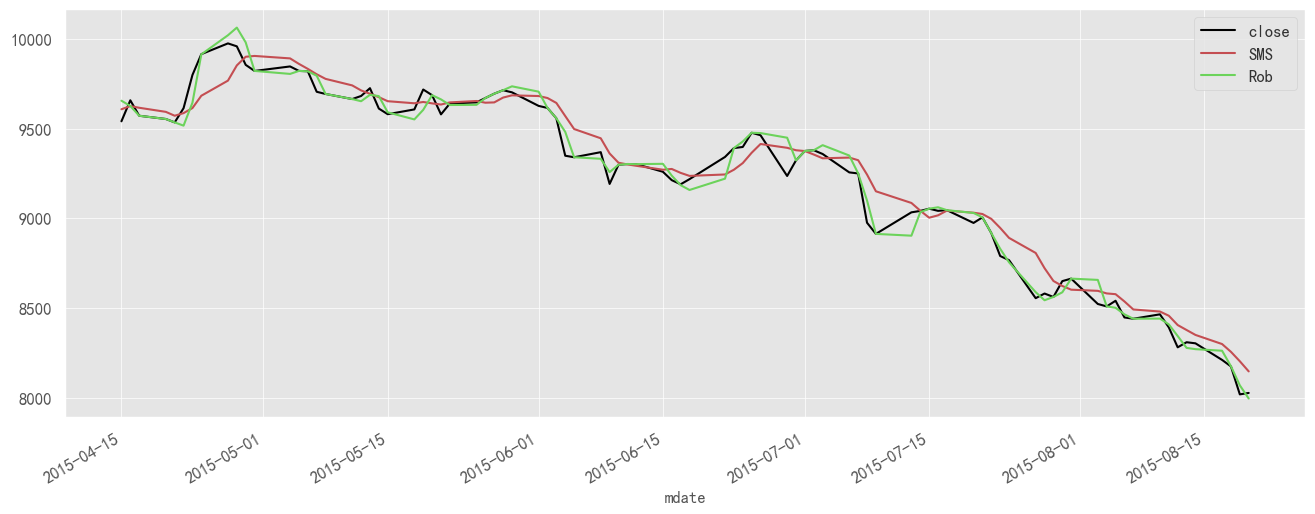

In [256]:
start_dt = pd.to_datetime("2015-04-15")
end_dt = pd.to_datetime("2015-08-20")
rob_ser:pd.Series = icu_ma.calc_icu_ma(close_ser,5)
close_ser.loc[start_dt:end_dt].plot(figsize=(16, 6), label="close", color="black")
close_ser.rolling(5).mean().loc[start_dt:end_dt].plot(color='r', label="SMS")
rob_ser.loc[start_dt:end_dt].plot(label="Rob", color="#6cd35b")
plt.legend()

In [257]:
# 
all_df: pd.DataFrame = pd.concat(
    (
        icu_ma.calc_icu_ma(close_ser,i) for i in np.arange(5, 205, 5)
    ),
    axis=1,
)
all_df.columns = np.arange(5, 205, 5)

In [259]:
import empyrical as ep

In [260]:
flag_frame: pd.DataFrame = (
    all_df.sub(close_ser, axis=0).mul(-1).apply(lambda x: np.where(x > 0, 1, 0))
)
cum_frame: pd.DataFrame = ep.cum_returns(flag_frame.mul(twse['roi'], axis=0))

In [261]:
cum_frame.iloc[-1].nlargest(10)

45     1.694817
50     1.340983
55     1.220325
40     1.081844
80     0.972958
105    0.954020
35     0.935709
60     0.932064
100    0.905289
110    0.844533
Name: 2025-04-21 00:00:00, dtype: float64

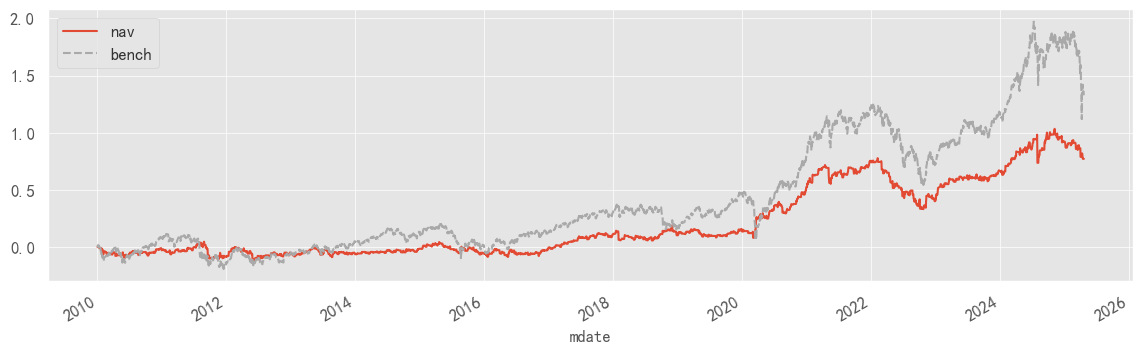

In [262]:
cum_frame[10].plot(label="nav",figsize=(14,4))
ep.cum_returns(close_ser.pct_change()).plot(label="bench", ls="--", color="darkgray")
plt.legend()

In [274]:
hs300 = df.rename(columns={
    "open_d": "open",
    "high_d": "high",
    "low_d": "low",
    "close_d": "close",
    "volume": "volume"  # 不需改名就保留
})

In [277]:
from typing import Dict, List, Union
import gradient_free_optimizers as gfo
search_space: Dict = {"N": np.arange(5, 205, 5)}

iterations: int = 20

# func = partial(runstrat,dataset=hs300)
opt = gfo.EvolutionStrategyOptimizer(search_space)
opt.search(lambda x: backtest.runstrat(x, dataset=hs300,method='ann'), n_iter=iterations)


Results: '<lambda>'  
   Best score: 8.318393729605802  
   Best parameter:
      'N' : 10  
 
   Random seed: 1994992066  
 
   Evaluation time   : 28.578060626983643 sec    [99.84 %]
   Optimization time : 0.04481673240661621 sec    [0.16 %]
   Iteration time    : 28.62287735939026 sec    [1.43 sec/iter]
 


{'N': 10}


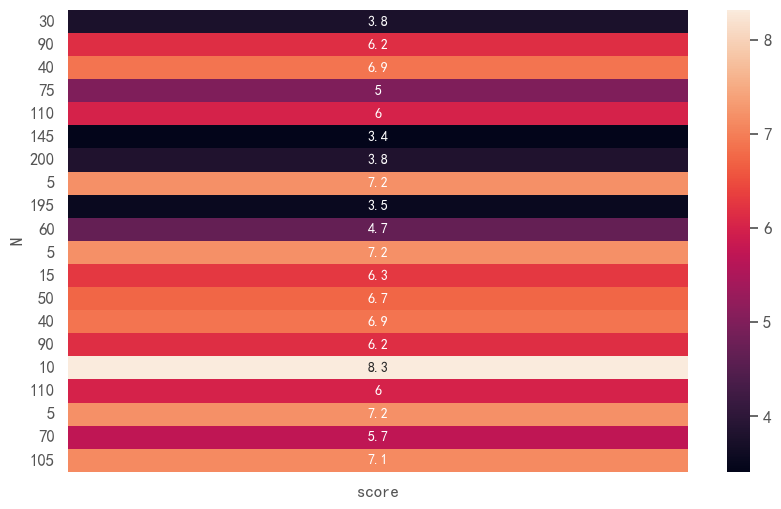

In [279]:
import seaborn as sns
sns.heatmap(opt.search_data.set_index('N'),annot=True)
print(opt.best_para)

In [281]:
result = backtest.get_backtest(hs300,**opt.best_para)

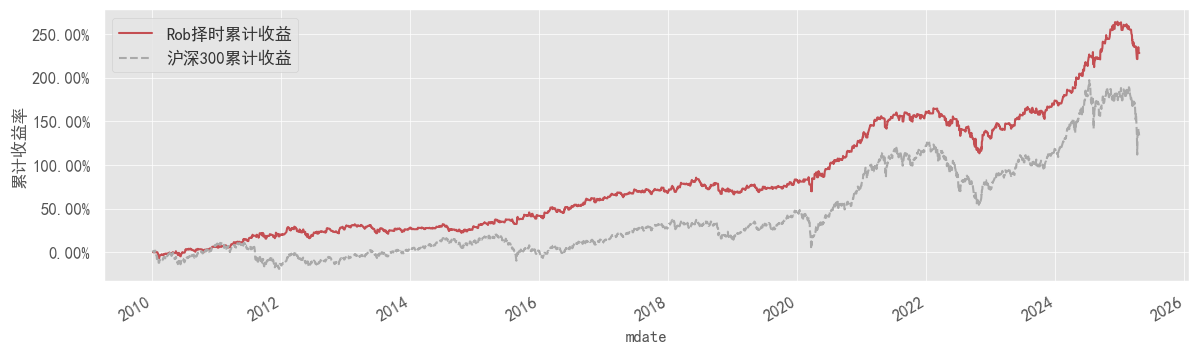

In [283]:
ret = pd.Series(result[0].analyzers._TimeReturn.get_analysis())
ax = ep.cum_returns(ret).plot(figsize=(14, 4), label="Rob择时累计收益", color="r")
ep.cum_returns(twse["close_d"].pct_change()).plot(
    ls="--", color="darkgray", label="沪深300累计收益", ax=ax
)
ax.set_ylabel('累计收益率')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
plt.legend()